# Sentiment Analysis

Dans le cadre du projet de la formation Data Engineering de chez Datascientest.com, je réalise un analyse de sentiment concernant les visiteurs de Disneyland Paris, L’analyse de sentiment est le processus qui consiste à déterminer l’opinion, le jugement et l’émotion qui se cache derrière le langage naturel.

# Librairies

###  Data Librairies

In [196]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### NLP Text Librairies

In [197]:
import re

from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer

### Exploratory Data Analysis 

In [198]:
from wordcloud import WordCloud

from PIL import Image

from sklearn.feature_extraction.text import CountVectorizer

### Feature Engineering

In [199]:
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

## Model Selection and Evaluation

In [200]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


# Dataset

Les données sont en format CSV, contiennent les avis des visiteurs au parc Disneyland Paris

### Read dataset

In [221]:
df = pd.read_csv('https://assets-datascientest.s3-eu-west-1.amazonaws.com/de/total/reviews.csv')
df.head()

,Rating,Year_Month,Reviewer_Location,Review_Text
0,5,2019-3,United Arab Emirates,"We've been to Disneyland Hongkong and Tokyo, s..."
1,4,2018-6,United Kingdom,I went to Disneyland Paris in April 2018 on Ea...
2,5,2019-4,United Kingdom,"What a fantastic place, the queues were decent..."
3,4,2019-4,Australia,We didn't realise it was school holidays when ...
4,5,missing,France,A Trip to Disney makes you all warm and fuzzy ...


### Shape dataset

In [202]:
df.shape

(13630, 4)

Les données contienent 13630 ligne et 4 colones

In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13630 entries, 0 to 13629
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Rating             13630 non-null  int64 
 1   Year_Month         13630 non-null  object
 2   Reviewer_Location  13630 non-null  object
 3   Review_Text        13630 non-null  object
dtypes: int64(1), object(3)
memory usage: 426.1+ KB


# Data Processing

### Checking Null values 

In [204]:
df.isnull().sum()

Rating               0
Year_Month           0
Reviewer_Location    0
Review_Text          0
dtype: int64

Les données ne contiennet aucune valeur nulle 

### Statistic description of dataset

In [206]:
print("Valuer unique de la colonne Rating: {}".format(df.Rating.unique()))
df.describe(include = "all")

Valuer unique de la colonne Rating: [5 4 2 3 1]


,Rating,Year_Month,Reviewer_Location,Review_Text
count,13630.000000,13630,13630,13630
unique,NaN,110,133,13628
top,NaN,missing,United Kingdom,ActiveX VT ERROR:
freq,NaN,936,7992,2
mean,3.960088,NaN,NaN,NaN
std,1.205324,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN
25%,3.000000,NaN,NaN,NaN
50%,4.000000,NaN,NaN,NaN
75%,5.000000,NaN,NaN,NaN


Les notes fournis par les visiteurs sont entre 1 et 5, la moyenne des notes est de 3.96


### Labelling review rased on ratings 

Les données ne contiennent aucune variable expliquée (target).

Les notes >= 3 sont considérés des commentaires positif et les notes < 3 sont considérés des commentaires négatif qui seront stockés dans la nouvelle colonne Sentiment qui prends la valeur 0 si le commentaire est négatif et 1 s'il est positif

In [207]:
pos_sentiment = len(df[df["Rating"] >= 3])
neg_sentiment = len(df[df["Rating"] < 3])

print(' - Il y a {} commentaires positifs'.format(pos_sentiment))
print(' - Il y a {} commentaires negatifs'.format(neg_sentiment))

 - Il y a 11758 commentaires positifs
 - Il y a 1872 commentaires negatifs


In [222]:
df['Sentiment'] = df['Rating'].apply(lambda x: 0 if x < 3 else 1)

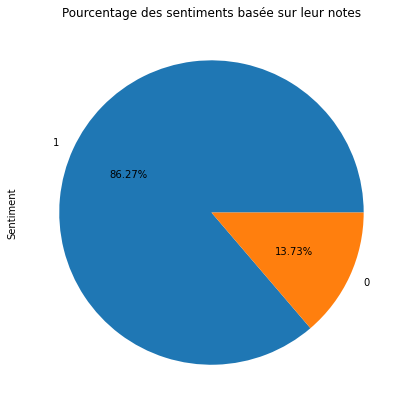

In [209]:
df.Sentiment.value_counts().plot(kind = "pie", autopct = "%1.2f%%", figsize=(7,7))
plt.title("Pourcentage des sentiments basée sur leur notes", loc = "center")
plt.show()

Le graphique ci-dessus montre que 86.27% des commentaires sont positifs contre 13.73% négatifs

# Text processing

In [210]:
mots_vide = ["also", "get", "going", "could", "however", "go", ")", "("]

stop_words = set(stopwords.words('english'))
stop_words.update(['.', ",", "?", "!", ";", ":", "-", "--", '"', "...", "..", "'", "i", "I", "they've", "they're", "they'll", "the", "so", "this", "in", "we're", "we've", "us", ""])
stop_words.update(mots_vide)
print(stop_words)

{'myself', 'am', "shouldn't", 'himself', 'while', "haven't", '', 'more', 'my', "wouldn't", 'too', 'y', "that'll", 'haven', 'don', 'he', 'when', 'and', 'nor', '--', "'", 'where', 'him', 'below', "they've", 'most', 'or', 'off', 'again', "mustn't", "we're", 'these', 'get', 'then', 'was', 'also', 'had', 'aren', '-', 'once', '..', 'ma', 'themselves', 'mustn', 'hers', 'us', 'ourselves', 'very', 'before', '!', 'doing', 'over', 'for', 'have', 'theirs', 'under', 're', "she's", "hadn't", 'weren', '"', 'I', "they'll", 'they', 'shan', 'own', 'yours', "shan't", 'an', 'won', 'go', 've', 'having', 'you', 'herself', 'because', 'out', 'wasn', "you're", 'i', 'above', 'couldn', 'their', 'yourself', "don't", 'that', 'as', 'at', 'how', 'with', 'so', 'hasn', "hasn't", 'his', 'there', 'o', 'from', 'however', 'whom', 'not', 'been', 'her', 'against', 'shouldn', 'should', 'through', 'm', 'needn', 'them', 'me', 'has', 'here', 'each', "it's", 'this', 'all', 'were', 'until', 'doesn', 'further', "you'll", "they're"

In [211]:
text = ''
for comment in df.Review_Text: text += comment + ' '


#Séparation les mots de la variable text
tokenizer = TweetTokenizer()
tokens = tokenizer.tokenize(text.lower())

Calcule le nombre de mot total ainsi que les mots unique de la variable text après la suppression des nombres et les saut de lignes ( qui contient tous les commentaires en un seul paragraphe )

In [212]:
def nombre_mot_unique(liste):
    liste_unique = []
    for mot in liste:
        if mot not in liste_unique:
            liste_unique.append(mot)
    return len(liste_unique)

print('Nombre total de mots: {} '.format(len(tokens)))
print('Nombre total de mots unique : {} '.format(nombre_mot_unique(tokens)))

Nombre total de mots: 2539901 
Nombre total de mots unique : 39051 


In [213]:
def stop_word_filtering(mots, stop_words):
    lemmatizer = WordNetLemmatizer()
    
    tokens = []
    for mot in mots:
        if mot not in stop_words:
            tokens.append(lemmatizer.lemmatize(mot))
    return tokens

tokens_filter_stop_words = stop_word_filtering(tokens, stop_words)

print('Nombre total de mots après suppression "stop_words" : {} '.format(len(tokens_filter_stop_words)))
print('Nombre total de mots unique après suppression "stop_words" : {} '.format(nombre_mot_unique(tokens_filter_stop_words)))

Nombre total de mots après suppression "stop_words" : 1140990 
Nombre total de mots unique après suppression "stop_words" : 36125 


Suppression des nombres et les saut de ligne, puis filtrage du stop words de la variable Review_Text, et enfin l'application un lemmatizer au mot de text qui transfome les mots en leur lemme qui correspond à un terme issu de l’usage ordinaire des locuteurs de la langue.

In [223]:
def Text_Processing(text, stop_words):
    
    # Suppression les nombres
    text = re.sub(r'\d+', '', text)

    #Suppression les saut de lignes
    text = re.sub('\n', '', text)
    
    #Séparation les mots de la variable text
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text.lower())
    
    lemmatizer = WordNetLemmatizer()
    
    tokens_drop_stop_word = []
    for mot in tokens:
        if mot not in stop_words:
            tokens_drop_stop_word.append(lemmatizer.lemmatize(mot))
    
    return(" ".join(tokens_drop_stop_word))

In [224]:
df.Review_Text = df.Review_Text.apply(lambda text: Text_Processing(text, stop_words))

# Exploratory Data Analysis

### Overview dataset

In [225]:
df.head(10)

,Rating,Year_Month,Reviewer_Location,Review_Text,Sentiment
0,5,2019-3,United Arab Emirates,disneyland hongkong tokyo far one best looking...,1
1,4,2018-6,United Kingdom,went disneyland paris april easter weekend kno...,1
2,5,2019-4,United Kingdom,fantastic place queue decent best time year ap...,1
3,4,2019-4,Australia,realise school holiday went consequently extre...,1
4,5,missing,France,trip disney make warm fuzzy actual kid big one...,1
5,5,2019-4,United Kingdom,magical experience recommend making free fast ...,1
6,5,missing,United Kingdom,boyfriend took birthday year god he's done gre...,1
7,5,2019-4,United Kingdom,everything amazing take lunch save time money ...,1
8,2,2019-4,Greece,booked ticket line disneyland something recomm...,0
9,4,2019-4,United Kingdom,park expected brilliant exciting kid magical.b...,1


Le tableau ci-dessus montre que la variable Review_Text est importante pour notre modèle.

### Other features

In [226]:
df.describe(include = "all")

,Rating,Year_Month,Reviewer_Location,Review_Text,Sentiment
count,13630.000000,13630,13630,13630,13630.000000
unique,NaN,110,133,13628,NaN
top,NaN,missing,United Kingdom,activex vt error,NaN
freq,NaN,936,7992,2,NaN
mean,3.960088,NaN,NaN,NaN,0.862656
std,1.205324,NaN,NaN,NaN,0.344223
min,1.000000,NaN,NaN,NaN,0.000000
25%,3.000000,NaN,NaN,NaN,1.000000
50%,4.000000,NaN,NaN,NaN,1.000000
75%,5.000000,NaN,NaN,NaN,1.000000


La description statistique de l'ensemble des données, montre que la majorité des commentaires provient de 'United Kingdom' avec 7992 commentaires sur 13630 en total, ce qui fait plus que la moitié. La description montre également 936 commentaires lui manque la date ('missing'). Ces variables donc sont moins importantes pour notre modèle de Machine learning 

In [227]:
df[df.Review_Text == "activex vt error"]

,Rating,Year_Month,Reviewer_Location,Review_Text,Sentiment
955,5,2018-8,France,activex vt error,1
3566,5,2016-5,Saudi Arabia,activex vt error,1


In [228]:
df = df.drop(df[df.Review_Text == "activex vt error"].index, axis = 0)
df.describe(include = "all")

,Rating,Year_Month,Reviewer_Location,Review_Text,Sentiment
count,13628.000000,13628,13628,13628,13628.000000
unique,NaN,110,133,13627,NaN
top,NaN,missing,United Kingdom,disneyland paris different disneyland park sle...,NaN
freq,NaN,936,7992,2,NaN
mean,3.959935,NaN,NaN,NaN,0.862636
std,1.205346,NaN,NaN,NaN,0.344244
min,1.000000,NaN,NaN,NaN,0.000000
25%,3.000000,NaN,NaN,NaN,1.000000
50%,4.000000,NaN,NaN,NaN,1.000000
75%,5.000000,NaN,NaN,NaN,1.000000


### Words counts

Separation les commentaires postifs et les négatis, puis les tokenizé et enfin filtrer les stop words

In [245]:
text= ""
for e in df.Review_Text:  text += e + ' '
text_pos = ""
for e in df.Review_Text[df.Sentiment == 1] :  text_pos += e + ' '
text_neg = ""
for e in df.Review_Text[df.Sentiment == 0] : text_neg += e + ' '

    
tokens_pos = tokenizer.tokenize(text_pos)
tokens_neg = tokenizer.tokenize(text_neg)
tokens = tokenizer.tokenize(text)

Text(0.5, 1.0, '20 mots les plus fréquemment employés par les internautes laissant des bons commentaires')

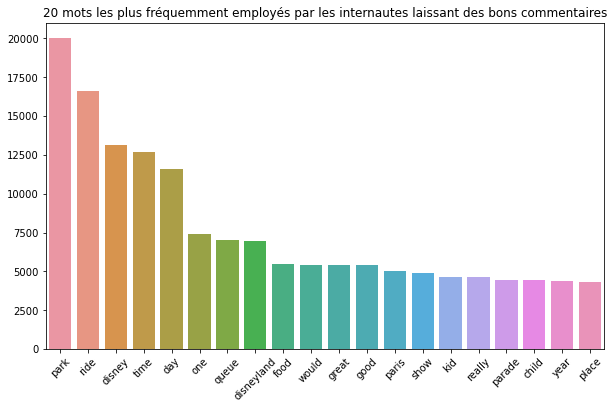

In [236]:
dico = Counter(tokens_pos)

mots = [m[0] for m in dico.most_common(20)]
freq = [m[1] for m in dico.most_common(20)]

plt.figure(figsize = (10, 6))
sns.barplot(x=mots, y=freq)
plt.xticks(rotation=45)
plt.title("20 mots les plus fréquemment employés par les internautes laissant des bons commentaires")

Text(0.5, 1.0, '20 mots les plus fréquemment employés par les internautes laissant des mauvais commentaires')

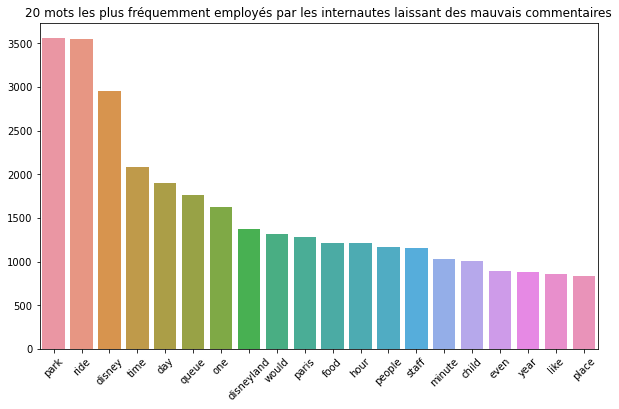

In [238]:
dico = Counter(tokens_neg)

mots = [m[0] for m in dico.most_common(20)]
freq = [m[1] for m in dico.most_common(20)]

plt.figure(figsize = (10, 6))
sns.barplot(x=mots, y=freq)
plt.xticks(rotation=45)
plt.title("20 mots les plus fréquemment employés par les internautes laissant des mauvais commentaires")

# WordCloud

Affichage 1000 nuages de mots les plus utilisés sur l'ensemble des données, en utilisant la librairies CordCloud

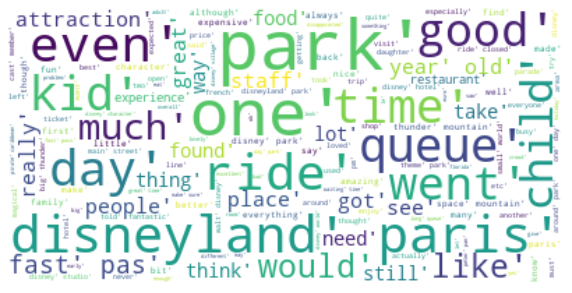

In [246]:
wc = WordCloud(background_color="white", stopwords=stop_words, max_words=1000, max_font_size=50, random_state=42)

plt.figure(figsize= (10,10)) # Initialisation d'une figure
wc.generate(str(tokens))           # "Calcul" du wordcloud
plt.imshow(wc, interpolation = 'bilinear') # Affichage
plt.axis('off') # Suppression des axes
plt.show()

#### Les 1000 mots les plus utilisés dans les commentaires positifs sous forme de coeur

In [240]:
def plot_word_cloud(text, masque, background_color = "white") :
    # Définir un masque
    mask_coloring = np.array(Image.open(str(masque)))

    # Définir le calque du nuage des mots
    wc = WordCloud(background_color=background_color, max_words=1000, mask = mask_coloring, max_font_size=50, random_state=42)

    # Générer et afficher le nuage de mots
    plt.figure(figsize= (20,10))
    wc.generate(str(text))
    plt.imshow(wc, interpolation = 'bilinear') # Affichage
    plt.axis('off') # Suppression des axes
    plt.show()

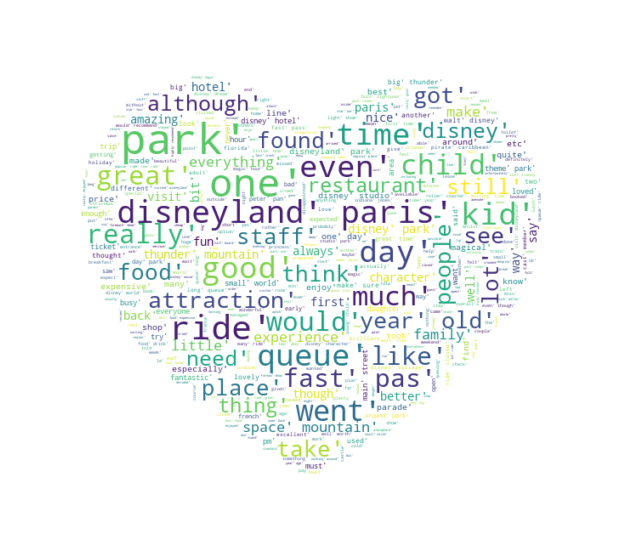

In [242]:
plot_word_cloud(tokens_pos, "img/coeur.png")

#### Les 1000 mots les plus utilisés dans les commentaires negatifs sous forme de triangle

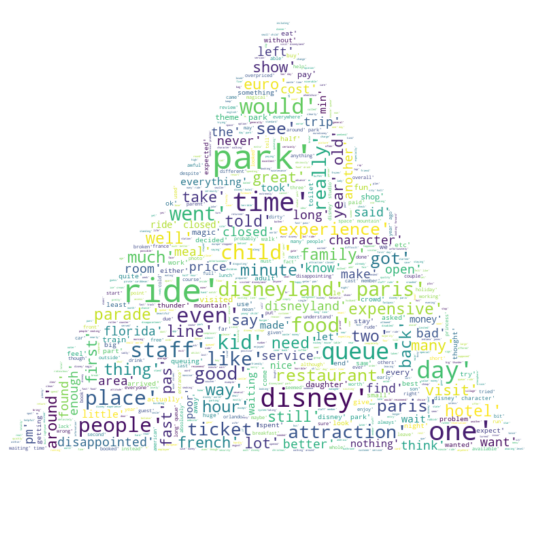

In [243]:
plot_word_cloud(tokens_neg, "img/mal.jpeg")

# Feature Engineering

In [247]:
df.head()

,Rating,Year_Month,Reviewer_Location,Review_Text,Sentiment
0,5,2019-3,United Arab Emirates,disneyland hongkong tokyo far one best looking...,1
1,4,2018-6,United Kingdom,went disneyland paris april easter weekend kno...,1
2,5,2019-4,United Kingdom,fantastic place queue decent best time year ap...,1
3,4,2019-4,Australia,realise school holiday went consequently extre...,1
4,5,missing,France,trip disney make warm fuzzy actual kid big one...,1


### Suppression des colonnes unitile

In [252]:
columns = ['Rating', 'Year_Month', 'Reviewer_Location']
df = df.drop(columns=columns, axis = 1)
df.head()

,Review_Text,Sentiment
0,disneyland hongkong tokyo far one best looking...,1
1,went disneyland paris april easter weekend kno...,1
2,fantastic place queue decent best time year ap...,1
3,realise school holiday went consequently extre...,1
4,trip disney make warm fuzzy actual kid big one...,1


### Calcul nombre de commentaires pour chaque sentiment

In [255]:
df.Sentiment.value_counts()

1    11756
0     1872
Name: Sentiment, dtype: int64

### Définir la variable explicative et la variable expliquée

Utilisation la bibliothéque TF-IDF pour donner du poids au variable explicative

In [257]:
# Définition de notre vectoriseur avec un total de mots de 5000 
TF_IDF = TfidfVectorizer(max_features = 5000, ngram_range = (2, 2))

X = df.Review_Text

X = TF_IDF.fit_transform(X)

# Check our matrix shape
X.shape

(13628, 5000)

In [258]:
y = df.Sentiment
y.shape

(13628,)

### Séparation l'ensemble de données en données de d'entrainement et de teste

In [259]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(10221, 5000) (3407, 5000) (10221,) (3407,)


# Model Selection and Evaluation

Afin de définir le meilleur modèle de classification, la méthode de cross validation est nécessaire, puis la mesure de métriques F1 score et la matrice de cnofusion

### Model Building

Nous utilisons la validation croisée K-Fold sur notre premier ensemble de données (avant le rééchantillonnage) car le CV lui-même n'est pas affecté par l'ensemble de données déséquilibré car il divise l'ensemble de données et prend en compte toutes les validations. Si nous utilisons le CV sur l'ensemble de données équilibré que nous avons obtenu du rééchantillonnage, nous devrions pouvoir obtenir un résultat similaire.

In [261]:
GBoosting = GradientBoostingClassifier()
DTree = DecisionTreeClassifier()
LogReg = LogisticRegression()
SVC = SVC()
RForest = RandomForestClassifier()
Bayes = BernoulliNB()
KNN = KNeighborsClassifier()

Models = [GBoosting, DTree, LogReg, RForest, Bayes, KNN]
Models_Dict = {0: "Gradint Boosting", 1: "Decision Tree", 2: "Logistic Regression", 3: "SVC", 4: "Random Forest", 5: "Naive Bayes", 6: "K-Neighbors"}



for i, model in enumerate(Models):
    print("{} Test Accuracy: {}".format(Models_Dict[i], cross_val_score(model, X, y, cv = 10, scoring = "accuracy").mean()))


Gradint Boosting Test Accuracy: 0.8718816358059606
Decision Tree Test Accuracy: 0.8285150446615666
Logistic Regression Test Accuracy: 0.8808329104732477
SVC Test Accuracy: 0.8703402165259109
Random Forest Test Accuracy: 0.8740083257649458
Naive Bayes Test Accuracy: 0.8599938806489529


D'après la validation croisée 10 fois, le modèle de la régression logisitique se distingue avec 88%, nous allons donc utilisé ce modèle pour la prédition de sentiments, la suite donc consiste les paramètres les plus optimale pour avoir une bonne résultat 

### Hyperparameter

In [263]:
Param = {"C": np.logspace(-4, 4, 50), "penalty": ['l1', 'l2']}
grid_search = GridSearchCV(estimator = LogisticRegression(random_state = 42), param_grid = Param, scoring = "accuracy", cv = 10, verbose = 0, n_jobs = -1)

grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Meilleur score: {:.2f} %".format(best_accuracy*100))
print("Meilleur parametre:", best_parameters)

Meilleur score: 89.08 %
Meilleur parametre: {'C': 5.428675439323859, 'penalty': 'l2'}


Nous avons donc une très bonne résultat avec 89%, avec les paramètres optimale {'C': 5.428675439323859, 'penalty': 'l2'}

### Modèle de la régression logistique 

In [266]:
clf = LogisticRegression(random_state = 42, C = 5.428675439323859, penalty = 'l2')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

### Metrics

Notre modèle est prêt nous allons donc le mesurer avec le F1-score et matrice de confusion 

In [268]:
accuracy_score(y_test, y_pred)

0.8925741121221016

Précision est plutôt bonne est de 0.89

In [271]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.37      0.48       457
           1       0.91      0.97      0.94      2950

    accuracy                           0.89      3407
   macro avg       0.80      0.67      0.71      3407
weighted avg       0.88      0.89      0.88      3407



Nous pouvons voir que les sentiments positif ont un très bon score de 0.94 qui seront très bien prédites contrairement au sentiment négatifs où on vas avoir un erreur de 50% un ppeu près 

In [272]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
confusion_matrix

Classe prédite,0,1
Classe réelle,,
0,168,289
1,77,2873


# Conclusion

Notre modèle nous donne un trés bonne prédiciton sur les sentiments positifs et beaucoup moins sur les négatifs cela du au nombre élevé des sentiments positifs contrairement au négatifs

- Notre modèle classe 289 sentiments positif (faux positif) sur 457 sentiments négatifs 
- Notre modèle classe 77 sentiments positif (vrai négatif) sur 2950 sentiments positifs 